In [1]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve, fmin
from astropy.io import fits
import scipy.interpolate as interp

%matplotlib widget
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'figure.facecolor': 'white'}) # this solves the black background issue
%config InlineBackend.figure_format='retina'

In [2]:
cnfw = 3.3 # NFW concentration parameter
z = 2.3 # redshift
Rs = 27 # kpc = Rvir = 90 kpc
H = cosmo.H(z).to('km/s/kpc').value

noise_level = 0.05
# print(H)
# M_h = 1e12*u.M_sun
# rho0 = 3*M_h/(4*np.pi*Rs**3) * 0.5
# A = 8*np.pi*c.G*rho0*Rs**3/(1*u.kpc)
A = 1.2e7 #* u.km**2/u.s**2

bres = 5 # kpc
min_b = 10 # kpc
max_b = 250 # kpc
bvec = np.arange(min_b, max_b, bres)
vrawsamp = np.arange(-1000, 1015, 30)

bm, vm = np.meshgrid(bvec, vrawsamp)

bvec_final = np.arange(min_b, max_b+2.5, 5)
vvec_final = np.arange(-1000, 1025, 50)

In [3]:
def vins(r, voff):
    vin = voff + H*r
    return vin

def vouts(r, vi):
    vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
    return vout

# def vouts(r, vi, gv):
#     vout = vi*(r/100)**(-gv) #np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
#     return vout
    
def ains(r, a0in, gin):
    ain = (a0in * (r/100)**(-gin))
    return ain

def aouts(r, a0out, gout):
    aout = (a0out * (r/100)**(-gout))
    # aout = a0out*r+gout
    return aout

/tmp/ipykernel_2692050/1904091197.py:6: RuntimeWarning: divide by zero encountered in divide
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2692050/1904091197.py:6: RuntimeWarning: invalid value encountered in multiply
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))


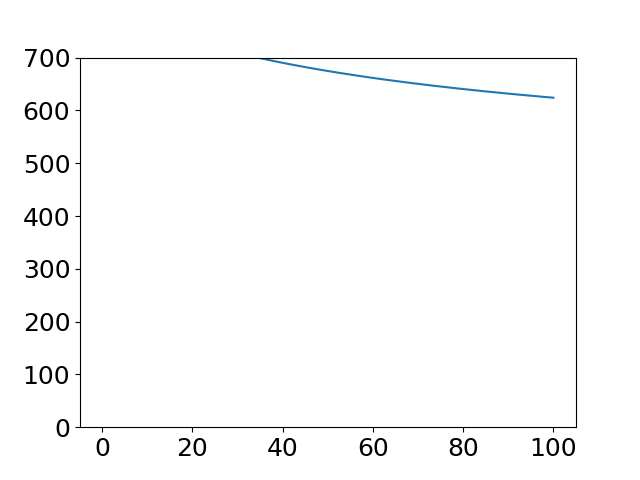

In [4]:
rr = np.linspace(0,100,1000)
plt.figure()
plt.plot(rr, vouts(rr, 800))
plt.ylim(0,700)
plt.show()

In [5]:
def model(theta):
    vi, voff, a0out, a0in, gout, gin = theta

    rmax = 5000
    # rmax_out = 100 * (a0out/noise_level)**(1/gout)
    rmax_out = 5000
    rmax_in = 5000
    # rmax_out = np.min([rmax_out_est, rmax])
    # print(rmax_out)
    # rmax_in_est = 100 * (a0in/noise_level)**(1/gin)
    
    # rmax_in = np.min([rmax_in_est, rmax])
    # print(rmax_in)

    rmax = 250 # kpc
    rmax_out = rmax
    rmax_in = rmax


    rawhmap = np.zeros((len(vrawsamp), len(bvec)))

    
    
    for bi, b in enumerate(bvec):

        lmax_out = np.sqrt(rmax_out**2 - b**2)
        lmax_in = np.sqrt(rmax_in**2 - b**2) #np.nanmin([np.sqrt((-voff/H)**2-b**2), np.sqrt(rmax_in**2 - b**2)])


        larr_slowl_out = np.linspace(-lmax_out, -200, 50)
        nfast_out = int(vi/900 * 1200 * np.exp(-b/200)) #1500
        larr_fast_out = np.linspace(-200, 200, nfast_out)
        larr_slowr_out = np.linspace(200, lmax_out, 50)
        larr_out = np.concatenate([larr_slowl_out, larr_fast_out, larr_slowr_out])
        r_out = np.sqrt(larr_out**2 + b**2)
        
        tau_outs = aouts(r_out, a0out, gout)
        tau_outs_arr = np.array(tau_outs)
        # print(tau_outs_arr)
        

        larr_slowl_in = np.linspace(-lmax_in, -100, 50)
        nfast_in = int(500 * np.exp(-b/100)) #1500
        larr_fast_in = np.linspace(-100, 100, nfast_in)
        larr_slowr_in = np.linspace(100, lmax_in, 50)
        larr_in = np.concatenate([larr_slowl_in, larr_fast_in, larr_slowr_in])
        r_in = np.sqrt(larr_in**2 + b**2)
        
        # lmaxcalc = np.sqrt((-voff/H)**2-b**2)
        # print(lmaxcalc)
        
        tau_ins = ains(r_in, a0in, gin)
        tau_ins_arr = np.array(tau_ins)

        # plt.figure()
        # plt.plot(larr_out, tau_outs, 'b.')
        # # plt.plot(larr_in, tau_ins, 'r.')
        # plt.show()
        

        vLOS_out = larr_out/r_out*vouts(r_out, vi)
        vLOS_in = larr_in/r_in*vins(r_in, voff)

        # plt.figure()
        # sc = plt.scatter(larr_out, vLOS_out, c=tau_outs)
        # sc1 = plt.scatter(larr_in, vLOS_in, c=tau_ins, cmap='inferno')
        # plt.xlabel('$\\ell$ (kpc)')
        # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
        # plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
        # plt.colorbar(sc1, label = '$\\tau_\\mathrm{in}$')
        # plt.title(f'$b={b}$ kpc')
        # plt.axhline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.axvline(0, c = 'k', alpha = 0.7, lw = 0.7, ls = '--')
        # plt.tight_layout()
        # plt.show()
    
        maxvout = np.nanmax(vLOS_out)
        maxvin = np.nanmax(vLOS_in)

        taulist_out = []
        taulist_in = []
        
        # bad b's
        if ~np.isfinite(maxvout):
            for j in vrawsamp:
                taulist_out.append([j, 0])
            continue
            
        if ~np.isfinite(maxvin):
            # print(f'bad {b}')
            for j in vrawsamp:
                taulist_in.append([j, 0])
            continue
        
        l_minvout = larr_out[np.argmin(vLOS_out)]
        l_maxvout = larr_out[np.argmax(vLOS_out)]

        l_minvin = larr_in[np.argmin(vLOS_in)]
        l_maxvin = larr_in[np.argmax(vLOS_in)]



        
        for vl in vrawsamp:
            # outflow
            if np.abs(vl) > maxvout:
                taulist_out.append([vl+15, 0])
            else:
                possible_values = larr_out[(vLOS_out > vl) & (vLOS_out < vl+30)]
                l_near = possible_values[(possible_values > l_minvout) & (possible_values < l_maxvout)]
                l_far = possible_values[(possible_values < l_minvout) | (possible_values > l_maxvout)]
        
                tau_near_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_near]
                tau_out_near = tau_outs_arr[tau_near_inds]
        
                
                tau_far_inds = [np.argwhere(larr_out == ln)[0][0] for ln in l_far]
                tau_out_far = tau_outs_arr[tau_far_inds]
                tau_tot_out = np.nan_to_num(np.nanmean(tau_out_near)) + np.nan_to_num(np.nanmean(tau_out_far))
    
                if np.isfinite(tau_tot_out):
                    taulist_out.append([vl+15, tau_tot_out])

            # inflow
            if np.abs(vl) > maxvin:
                taulist_in.append([vl+15, 0])
            else:
                possible_values = larr_in[(vLOS_in > vl) & (vLOS_in < vl+30)]
                # print(possible_values)
                l_near = possible_values[(possible_values < l_minvin) & (possible_values > l_maxvin)]
                l_far = possible_values[(possible_values > l_minvin) | (possible_values < l_maxvin)]
        
                tau_near_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_near]
                tau_in_near = tau_ins_arr[tau_near_inds]
        
                
                tau_far_inds = [np.argwhere(larr_in == ln)[0][0] for ln in l_far]
                tau_in_far = tau_ins_arr[tau_far_inds]
                tau_tot_in = np.nan_to_num(np.nanmean(tau_in_near)) + np.nan_to_num(np.nanmean(tau_in_far))
                # print(tau_tot)
    
                if np.isfinite(tau_tot_in):
                    taulist_in.append([vl+15, tau_tot_in])
        
        tauarr_out = np.array(taulist_out) # v, tau
        tauarr_in = np.array(taulist_in)

        if len(tauarr_out) == 0:
            tout = vrawsamp*0.0
        else:
            tout = np.interp(vrawsamp, tauarr_out[:,0], tauarr_out[:,1], left=0, right=0)

        if len(tauarr_in) == 0:
            tin = vrawsamp*0.0
        else:
            tin = np.interp(vrawsamp, tauarr_in[:,0], tauarr_in[:,1], left=0, right=0)

        rawhmap[:,bi] = tout + tin
            # tau_tot = tau_tot_out + tau_tot_in
            # taulist.append([b, vl+15, tau_tot])

    
    

    # points = tauarr[:,0:2]
    # values = tauarr[:,2]
    # rawhmap = interp.griddata(points, values, (bm, vm), method='nearest')

    # plt.figure()
    # plt.imshow(rawhmap, origin='lower')
    # plt.show()


    
    
    # print(tauarr_out[np.isfinite(tauarr_out[:,2])])
    # plt.figure()
    # plt.scatter(tauarr_out[:,1], tauarr_out[:,2])
    # plt.plot(vrawsamp, tout)
    # plt.plot(vrawsamp, tin)
    # plt.show()


    # plt.figure()
    # sc = plt.scatter(tauarr_out[:,0], tauarr_out[:,1], c=tauarr_out[:,2]) #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    # plt.colorbar(sc, label = '$\\tau_\\mathrm{out}$')
    
    # # tin = plt.scatter(tauarr_in[:,0], tauarr_in[:,1], c=tauarr_in[:,2], cmap='plasma_r') #/cmap='inferno_r' vmin=2e-2, vmax = 1e-1 norm=matplotlib.colors.LogNorm()
    # # plt.colorbar(tin, label = '$\\tau_\\mathrm{in}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.tight_layout()
    # plt.show()
    
    # make map
    
    # vres = 10 #50
    # vlosr = np.arange(-1000, 1000, vres)
    
    # hmap = np.zeros((len(vlosr), len(bvec)))
    
    # for bi, b in enumerate(bvec):
    #     bcut_out = (tauarr_out[:,0] == b)
    #     bcut_in = (tauarr_in[:,0] == b)
    
    #     for vind, v in enumerate(vlosr):
    #         vcut_out = (tauarr_out[:,1] > v) & (tauarr_out[:,1] < v+vres)
    #         vcut_in = (tauarr_in[:,1] > v) & (tauarr_in[:,1] < v+vres)
            
    #         tauavg_out = np.nanmean(tauarr_out[:,2][bcut_out & vcut_out])
    #         if ~np.isfinite(tauavg_out):
    #             tauavg_out = 0
    
    #         tauavg_in = np.nanmean(tauarr_in[:,2][bcut_in & vcut_in])
    #         if ~np.isfinite(tauavg_in):
    #             tauavg_in = 0

    #         hmap[vind,bi] = tauavg_out + tauavg_in

    hmap_conv = convolve(rawhmap, Gaussian2DKernel(1,1), boundary = 'extend') # 100 km/s and 5 kpc sampling

    f = interp.RectBivariateSpline(vrawsamp, bvec, hmap_conv, kx=3, ky=3)
    hmap_reshaped = f(vvec_final, bvec_final)
    
    # print(new_im.shape)
    
    # plt.figure()
    # plt.imshow(hmap_reshaped, aspect='auto', origin='lower', extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()])
    # plt.show()
    
    # # # print(hmap.shape)
    # plt.figure()
    # us = plt.imshow(rawhmap, origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
    #            aspect='auto', cmap='plasma')
    # plt.colorbar(us, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Unsmoothed')
    # # plt.xscale('log')
    # plt.show()
    
    # plt.figure()
    # sm = plt.imshow(hmap_conv, origin='lower', extent = (bvec[0], bvec[-1], vrawsamp[0], vrawsamp[-1]), 
    #            aspect='auto', cmap='inferno')
    # plt.colorbar(sm, label = '$\\tau_\\mathrm{tot}$')
    # plt.xlabel('b (kpc)')
    # plt.ylabel('$v_\\mathrm{LOS}$ (km/s)')
    # plt.title('Smoothed')
    # # plt.xscale('log')
    # plt.show()

    return hmap_reshaped
    


In [6]:
lya_real = fits.open('lya_conv_240811.fits')[0].data
lya_err_real = fits.open('lya_error_conv_240811.fits')[0].data
# binterp_vec = np.arange(10,252.5,5)
# vinterp_vec = np.arange(-1000, 1050, 100)

In [7]:
def lnlike(theta):
    return -0.5 * np.nansum(((lya_real - model(theta))/lya_err_real)**2), model(theta)

In [8]:
rr = np.linspace(10,250, 1000)*u.kpc
rvir = 90*u.kpc
vvir = np.sqrt(c.G*1e12*u.M_sun/rvir)
x = rr/rvir

def f(x):
    return np.log(1+x) + x/(1+x)

vcirc = vvir * np.sqrt(f(cnfw*x)/(x*f(cnfw)))
vcirc = np.sqrt(c.G*1e12*u.M_sun/rr)

vcirc = np.sqrt(vvir**2/x*(np.log(1+cnfw*x)-(cnfw*x)/(1+cnfw*x))/(np.log(1+cnfw)-cnfw/(1+cnfw)))

vesc = np.sqrt(2*c.G*1e12*u.M_sun/rr*np.log(1+cnfw*rr/rvir)/(np.log(1+cnfw)-cnfw/(1+cnfw)))


<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:43: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2692050/3940285523.py:27: SyntaxWarning: invalid escape sequence '\

-556.2042522617595


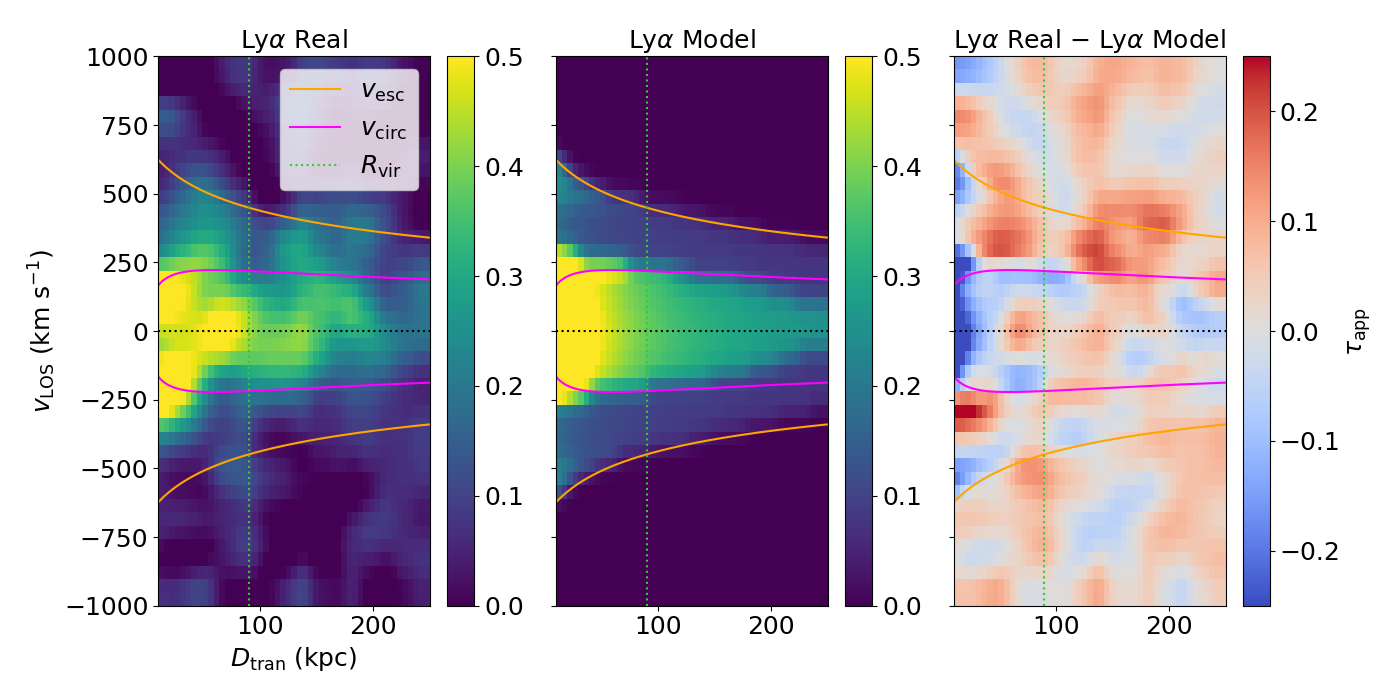

In [12]:
theta = 756, -292, 0.1, 0.27, 0.27, 0.45 #vout, vin, aout, ain, gout, gin, gv
# 830, -269, 0.1, 0.17, 0.1, 0.2
#756, -311, 0.1, 0.27, 0.26, 0.45
#756, -311, 0.1, 0.17, 0.26, 0.45 this is okay
# 712, -311, 0.37, 0., 0.21, 0.4 # out only
likelihood, lya_model = lnlike(theta)
print(likelihood)
vmi, vma = 0, 0.5

fig, ax = plt.subplots(1,3, figsize = (14,7), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Ly$\\alpha$ Real', fontsize = 18)

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Ly$\\alpha$ Model', fontsize = 18)

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='coolwarm', vmin=-0.25, vmax=0.25)
fig.colorbar(diff, ax=ax[2], label = '$\\tau_\\mathrm{app}$')
ax[2].set_title('Ly$\\alpha$ Real $-$ Ly$\\alpha$ Model', fontsize = 18)
fig.tight_layout()

ax[0].plot(rr, vesc.to('km/s'), label = '$v_\mathrm{esc}$', c='orange')
ax[0].plot(rr, vcirc.to('km/s'), c='magenta', label = '$v_\mathrm{circ}$')
ax[0].plot(rr, -vesc.to('km/s'), c='orange')
ax[0].plot(rr, -vcirc.to('km/s'), c='magenta')
ax[0].axvline(90, ls = ':', c='limegreen', label = '$R_\mathrm{vir}$')

ax[1].plot(rr, vesc.to('km/s'), label = '$v_\mathrm{esc}$', c='orange')
ax[1].plot(rr, vcirc.to('km/s'), c='magenta', label = '$v_\mathrm{circ}$')
ax[1].plot(rr, -vesc.to('km/s'), c='orange')
ax[1].plot(rr, -vcirc.to('km/s'), c='magenta')
ax[1].axvline(90, ls = ':', c='limegreen', label = '$R_\mathrm{vir}$')

ax[2].plot(rr, vesc.to('km/s'), label = '$v_\mathrm{esc}$', c='orange')
ax[2].plot(rr, vcirc.to('km/s'), c='magenta', label = '$v_\mathrm{circ}$')
ax[2].plot(rr, -vesc.to('km/s'), c='orange')
ax[2].plot(rr, -vcirc.to('km/s'), c='magenta')
ax[2].axvline(90, ls = ':', c='limegreen', label = '$R_\mathrm{vir}$')

ax[0].set_xlabel('$D_\\mathrm{tran}$ (kpc)')
ax[0].set_ylabel('$v_\\mathrm{LOS}$ (km s$^{-1}$)')

ax[0].axhline(0, ls=':', c='k')
ax[1].axhline(0, ls=':', c='k')
ax[2].axhline(0, ls=':', c='k')
ax[0].legend()
fig.tight_layout()
plt.savefig('out+in_model_241202.pdf')

plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:28: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2692050/1378007340.py:28: SyntaxWarning: invalid escape sequence '\m'
  ax[i].plot(rr, vesc.to('km/s'), label = '$v_\mathrm{esc}$', c='orange')
/tmp/ipykernel_2692050/1378007340.py:29: SyntaxWarning: invalid escape sequence '\m'
  ax[i].plot(rr, vcirc.to('km/s'), c='magenta', label = '$v_\mathrm{circ}$')
/tmp/ipykernel_2692050/1378007340.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax[i].axvline(90, ls = ':', c='limegreen', label = '$R_\mathrm{vir}$')
/tmp/ipykernel_2692050/107033359.py:119: RuntimeWarning: Mean of empty slice
  tau_tot_out = np.nan_to_num(np.nanmean(tau_out_near)) + np.nan_to_num(np.nanmean(tau_out_far))
/tmp/ipykernel_2692050/107033359.py:139: 

-750.7795626882933


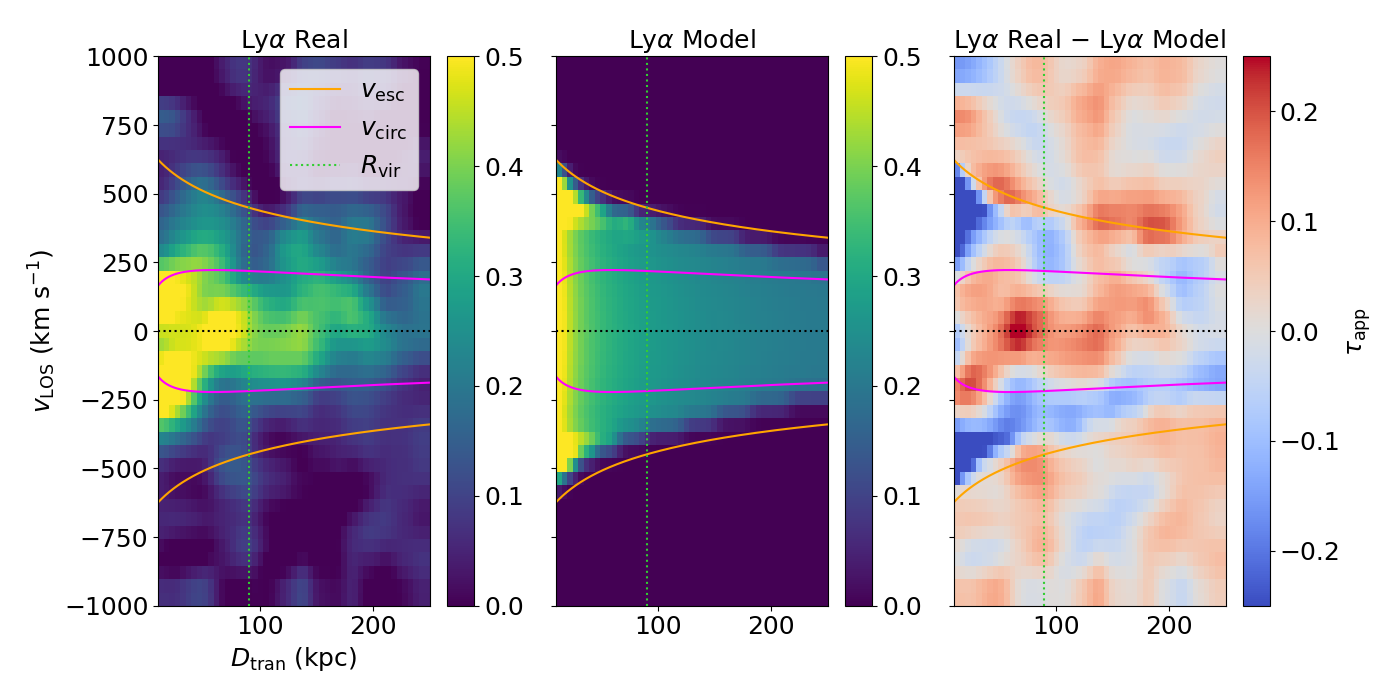

In [14]:
theta = 712, -311, 0.27, 0., 0.31, 0.4 #vout, vin, aout, ain, gout, gin, gv
# 830, -269, 0.1, 0.17, 0.1, 0.2
#756, -311, 0.1, 0.27, 0.26, 0.45
#756, -311, 0.1, 0.17, 0.26, 0.45 this is okay
# 712, -311, 0.37, 0., 0.21, 0.4 # out only
likelihood, lya_model = lnlike(theta)
print(likelihood)
vmi, vma = 0, 0.5

fig, ax = plt.subplots(1,3, figsize = (14,7), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Ly$\\alpha$ Real', fontsize = 18)

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Ly$\\alpha$ Model', fontsize = 18)

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='coolwarm', vmin=-0.25, vmax=0.25)
fig.colorbar(diff, ax=ax[2], label = '$\\tau_\\mathrm{app}$')
ax[2].set_title('Ly$\\alpha$ Real $-$ Ly$\\alpha$ Model', fontsize = 18)
fig.tight_layout()

for i in range(3):
    ax[i].plot(rr, vesc.to('km/s'), label = '$v_\mathrm{esc}$', c='orange')
    ax[i].plot(rr, vcirc.to('km/s'), c='magenta', label = '$v_\mathrm{circ}$')
    ax[i].plot(rr, -vesc.to('km/s'), c='orange')
    ax[i].plot(rr, -vcirc.to('km/s'), c='magenta')
    ax[i].axvline(90, ls = ':', c='limegreen', label = '$R_\mathrm{vir}$')

ax[0].set_xlabel('$D_\\mathrm{tran}$ (kpc)')
ax[0].set_ylabel('$v_\\mathrm{LOS}$ (km s$^{-1}$)')


ax[0].axhline(0, ls=':', c='k')
ax[1].axhline(0, ls=':', c='k')
ax[2].axhline(0, ls=':', c='k')
ax[0].legend()

fig.tight_layout()

plt.savefig('outonly_model_241202.pdf')

plt.show()

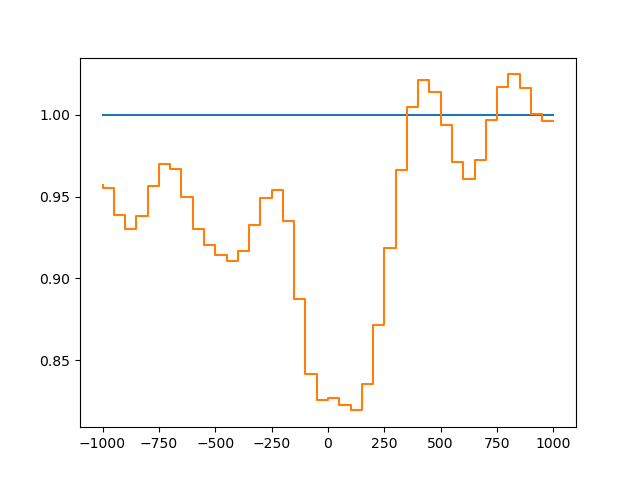

In [77]:
plt.figure()
plt.step(vvec_final, np.exp(-lya_model[:,48]))
plt.step(vvec_final, np.exp(-lya_real[:,48]))
plt.show()

In [ ]:
theta = 756, -292, 0.1, 0.27, 0.27, 0.45 #vout, vin, aout, ain, gout, gin, gv
# 830, -269, 0.1, 0.17, 0.1, 0.2
#756, -311, 0.1, 0.27, 0.26, 0.45
#756, -311, 0.1, 0.17, 0.26, 0.45 this is okay
# 712, -311, 0.37, 0., 0.21, 0.4 # out only
likelihood, lya_model = lnlike(theta)
print(likelihood)
vmi, vma = 0, 0.5

fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='bwr', vmin=-0.25, vmax=0.25)
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()